In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas_profiling as pp

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import  roc_auc_score
from scipy import stats
from sklearn.ensemble import  GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

pd.options.display.max_info_columns = 999
pd.options.display.max_info_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_seq_items = 999
pd.options.display.float_format = '{:.7f}'.format

warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv('clear_data_7.csv')

In [25]:
df.head()

,id,target,base_station_cnt,area_cnt_x,region_city_x,area_city_x,sms_cnt,distinct_number_cnt,distinct_number/sms_x,day,mean_call_to_period,std_call_to_period,duration_nval_mean,duration_nval_std,ratio_call,preffered_location_region,refilled_amount_x,activity_voice_days_ind,activity_data_days_ind,activity_sms_days_ind,voice_on_net_ind_x,voice_off_net_ind_x,international_calls_ind_x,sms_ind_x,internet_ind_x,act_off_net_voice_days_ind,on_net_outgoing_calls_min_we_x,on_net_outgoing_calls_min_bd,off_net_outgoing_calls_min_we_x,off_net_outgoing_calls_min_bd,on_net_outgoing_calls_count_we,on_net_outgoing_calls_count_bd,off_net_out_calls_count_we,off_net_out_calls_count_bd,on_net_out_revenue_core_we_x,on_net_out_revenue_core_bd_x,off_net_out_revenue_core_we_x,off_net_out_revenue_core_bd_x,outgoing_sms_count_x,outgoing_sms_count_we_x,sms_revenue_core_we_x,sms_revenue_core_bd_x,roaming_sms_revenue_core_we_x,roaming_sms_revenue_core_bd,outgoing_mms_count_x,outgoing_mms_count_we_x,outgoing_mms_count_bd_x,int_outgoing_calls_min_x,roaming_outgoing_calls_min_x,other_outgoing_calls_min_x,outgoing_sms_int_count_x,roaming_outgoing_sms_count,mobile_data_mb_x,roaming_mobile_data_mb_x,total_incoming_calls_min,off_net_incoming_calls_min_x,int_incoming_calls_min_x,roaming_incoming_calls_min_x,int_outgoing_calls_count_x,total_incoming_calls_count,off_net_incoming_calls_count,int_incoming_calls_count_x,total_outgoing_revenue_core_x,periodic_fees_core,non_periodic_fees_core_x,int_outgoing_revenue_core_x,roaming_outgoing_revenue_core_x,roaming_incoming_revenue_core_x,mobile_data_revenue_core_x,other_vas_revenue_core_x,total_itc_revenue_x,off_net_itc_revenue_x,total_itc_cost_x,off_net_itc_cost_x,total_sms_revenue_x,off_net_sms_revenue_x,total_sms_cost_x,off_net_sms_cost,international_sms_cost,mobile_data_3g_mb_x,mobile_data_200_free_mb_x,roaming_ind_x,activity_data_4g_days_cnt,mobile_data_4g_mb_x,base_station_cnt_2,area_cnt_2,region_city_2,area_city_2,sms_cnt_2,distinct_number_cnt_2,distinct_number/sms_2,day_2,mean_call_to_period_2,duration_nval_mean_2,duration_nval_std_2,ratio_call_2,preffered_location_region_2,refilled_amount_2,activity_voice_days_ind_2,activity_data_days_ind_2,activity_sms_days_ind_2,voice_on_net_ind_2,voice_off_net_ind_2,international_calls_ind_2,sms_ind_2,internet_ind_2,act_off_net_voice_days_ind_2,on_net_outgoing_calls_min_we_2,on_net_outgoing_calls_min_bd_2,off_net_outgoing_calls_min_we_2,off_net_outgoing_calls_min_bd_2,on_net_outgoing_calls_count_we_2,on_net_outgoing_calls_count_bd_2,off_net_out_calls_count_we_2,off_net_out_calls_count_bd_2,on_net_out_revenue_core_we_2,on_net_out_revenue_core_bd_2,off_net_out_revenue_core_we_2,off_net_out_revenue_core_bd_2,outgoing_sms_count_2,outgoing_sms_count_we_2,sms_revenue_core_we_2,sms_revenue_core_bd_2,roaming_sms_revenue_core_we_2,roaming_sms_revenue_core_bd_2,outgoing_mms_count_2,outgoing_mms_count_we_2,int_outgoing_calls_min_2,roaming_outgoing_calls_min_2,other_outgoing_calls_min_2,outgoing_sms_off_net_count_2,outgoing_sms_int_count_2,roaming_outgoing_sms_count_2,mobile_data_mb_2,roaming_mobile_data_mb_2,total_incoming_calls_min_2,off_net_incoming_calls_min_2,int_incoming_calls_min_2,roaming_incoming_calls_min_2,int_outgoing_calls_count_2,roaming_outgoing_calls_count_2,total_incoming_calls_count_2,off_net_incoming_calls_count_2,int_incoming_calls_count_2,roaming_incoming_calls_count_2,total_outgoing_revenue_core_2,periodic_fees_core_2,non_periodic_fees_core_2,int_outgoing_revenue_core_2,roaming_outgoing_revenue_core_2,roaming_incoming_revenue_core_2,mobile_data_revenue_core_2,other_vas_revenue_core_2,total_itc_revenue_2,off_net_itc_revenue_2,total_itc_cost_2,off_net_itc_cost_2,total_sms_revenue_2,off_net_sms_revenue_2,total_sms_cost_y,sms_revenue_int_core,mobile_data_3g_mb_2,mobile_data_200_free_mb_2,roaming_ind_2,activity_data_4g_days_cnt_2,mobile_data_4g_mb_2,base_station_cnt_3,area_cnt_3,region_city_3,area_city_3,sms_cnt_3,distinct_number_cnt_3,distinct_number/sms_3,day_3,mean_call_

In [26]:
df.shape

(38746, 439)

In [27]:
df.fillna(0, inplace=True)

In [28]:
#X = pd.concat([df_cat, df_num], axis=1)
X = df
y = X.target
X.drop(['target', 'id'], axis=1, inplace=True)

In [29]:
X.shape

(38746, 437)

###  Lightgbm 

In [20]:
parameters_lgb = {
    'application': 'binary',
    'metric': 'AUC',
    'boosting': 'gbdt',
    'num_leaves':15,
    'max_depth': 12,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'learning_rate': 0.01
}

In [9]:
%%time

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
i=1
results = pd.DataFrame()

models_lgb= []

y_oof_lgb = np.zeros(len(y.values))


for trainIdx, testIdx in cv.split(X, y):
    
# lightgbm
    train_data = lgb.Dataset(X.values[trainIdx], label=y.values[trainIdx])
    test_data = lgb.Dataset(X.values[testIdx], label=y.values[testIdx])
    model = lgb.train(parameters_lgb,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=6000,
                       early_stopping_rounds=300, verbose_eval = 1000)
    
    train_predicted_lgb = model.predict(X.values[trainIdx])
    test_predicted_lgb = model.predict(X.values[testIdx])
 
    
    train_predicted_ensemble = train_predicted_lgb   
    test_predicted_ensemble = test_predicted_lgb  
    
    results.loc[i,'accuracy_train'] = accuracy_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'accuracy_test'] = accuracy_score(y[testIdx], test_predicted_ensemble.round())
    
    results.loc[i,'precision_train'] = precision_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'precision_test'] = precision_score(y[testIdx], test_predicted_ensemble.round())
    
    
    results.loc[i,'recall_train'] = recall_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'recall_test'] = recall_score(y[testIdx], test_predicted_ensemble.round())
    
    
    results.loc[i,'roc_auc_train'] = roc_auc_score(y[trainIdx], train_predicted_ensemble) 
    results.loc[i,'roc_auc_test'] = roc_auc_score(y[testIdx], test_predicted_ensemble) 
    
    results.loc[i,'f1_score_train'] = f1_score(y[trainIdx], train_predicted_ensemble.round()) 
    results.loc[i,'f1_score_test'] = f1_score(y[testIdx], test_predicted_ensemble.round()) 
    models_lgb.append(model)
    
    i+=1

Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.836809
Early stopping, best iteration is:
[1240]	valid_0's auc: 0.837039
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.835872
[2000]	valid_0's auc: 0.839369
[3000]	valid_0's auc: 0.840325
Early stopping, best iteration is:
[2805]	valid_0's auc: 0.840485
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.835066
[2000]	valid_0's auc: 0.839449
Early stopping, best iteration is:
[2600]	valid_0's auc: 0.841067
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.83895
[2000]	valid_0's auc: 0.839431
Early stopping, best iteration is:
[1737]	valid_0's auc: 0.839727
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.820814
Early stopping, best iteration is:
[1560]	valid_0's auc: 0.822268
Wall time: 3min 43s


In [13]:
np.mean(results)

accuracy_train    0.9486269
accuracy_test     0.9042740
precision_train   0.9617803
precision_test    0.6296610
recall_train      0.5315811
recall_test       0.2247883
roc_auc_train     0.9736557
roc_auc_test      0.8371034
f1_score_train    0.6776559
f1_score_test     0.3310598
dtype: float64

In [10]:
pd.DataFrame(np.mean(results)).transpose()

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,f1_score_train,f1_score_test
0,0.9360062,0.9043256,0.9263542,0.6314178,0.4258557,0.2254279,0.9561635,0.8361171,0.5823118,0.3320113


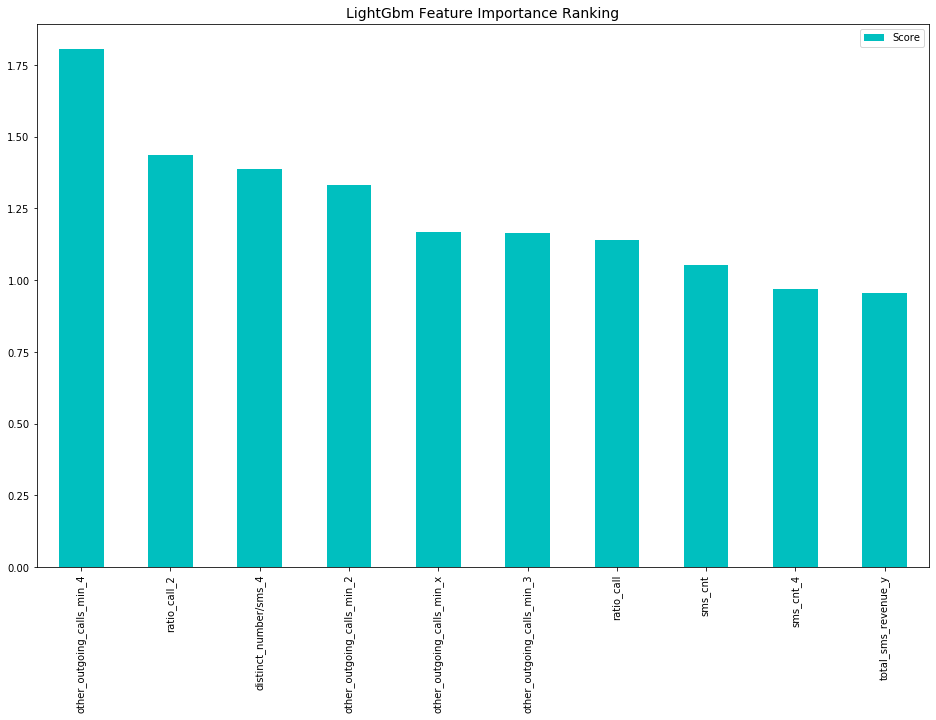

,Feature,Score
287,other_outgoing_calls_min_4,1.8040293
93,ratio_call_2,1.4377289
255,distinct_number/sms_4,1.3873626
127,other_outgoing_calls_min_2,1.3324176
47,other_outgoing_calls_min_x,1.1675824
210,other_outgoing_calls_min_3,1.1630037
12,ratio_call,1.1401099
4,sms_cnt,1.0531136
253,sms_cnt_4,0.9706960
430,total_sms_revenue_y,0.9569597


In [11]:
importances = pd.DataFrame(np.array([pd.Series(X.columns), pd.Series(model.feature_importance()*100./np.sum(model.feature_importance()))]).transpose(),
                          columns=['Feature', 'Score']).sort_values('Score', ascending=False)

plt.rcParams["figure.figsize"] = (16,10)
ax = importances[:10].plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("LightGbm Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

plt.show()

importances[:15]

### XGBClassifier

In [30]:
parameters_xgb = {'subsample': 0.7, 'scale_pos_weight': 1, 'reg_alpha': 1e-05, 'random_state': 42, 
              'objective': 'binary:logistic', 'n_jobs': 4,
 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1.0}

In [31]:
%%time
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 
           
results = pd.DataFrame() 
models_xgb = []
y_oof_xgb = np.zeros(len(y.values))

i=1
for trainIdx, testIdx in kf.split(X,y): 
    print(i)
        
    #XGBClassifier
    xgb = XGBClassifier(**parameters_xgb)
    xgb.fit(X.iloc[trainIdx,:], y[trainIdx]) 
    train_predicted_xgb = xgb.predict_proba(X.iloc[trainIdx,:])[:, 1] 
    test_predicted_xgb = xgb.predict_proba(X.iloc[testIdx,:])[:, 1] 
    
      
    train_predicted_ensemble = train_predicted_xgb
    test_predicted_ensemble = test_predicted_xgb
    
    results.loc[i,'accuracy_train'] = accuracy_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'accuracy_test'] = accuracy_score(y[testIdx], test_predicted_ensemble.round())
    
    results.loc[i,'precision_train'] = precision_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'precision_test'] = precision_score(y[testIdx], test_predicted_ensemble.round())
    
    
    results.loc[i,'recall_train'] = recall_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'recall_test'] = recall_score(y[testIdx], test_predicted_ensemble.round())
    
    
    results.loc[i,'roc_auc_train'] = roc_auc_score(y[trainIdx], train_predicted_ensemble) 
    results.loc[i,'roc_auc_test'] = roc_auc_score(y[testIdx], test_predicted_ensemble) 
    
    results.loc[i,'f1_score_train'] = f1_score(y[trainIdx], train_predicted_ensemble.round()) 
    results.loc[i,'f1_score_test'] = f1_score(y[testIdx], test_predicted_ensemble.round()) 
    models_lgb.append(model)
    
    i+=1

1
2
3
4
5
Wall time: 2min 35s


In [32]:
pd.DataFrame(np.mean(results)).transpose()

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,roc_auc_train,roc_auc_test,f1_score_train,f1_score_test
0,0.9185335,0.9030352,0.8085054,0.6210667,0.2990831,0.2085575,0.8911697,0.8294359,0.4365634,0.3121409


In [33]:
np.mean(results)

accuracy_train    0.9185335
accuracy_test     0.9030352
precision_train   0.8085054
precision_test    0.6210667
recall_train      0.2990831
recall_test       0.2085575
roc_auc_train     0.8911697
roc_auc_test      0.8294359
f1_score_train    0.4365634
f1_score_test     0.3121409
dtype: float64

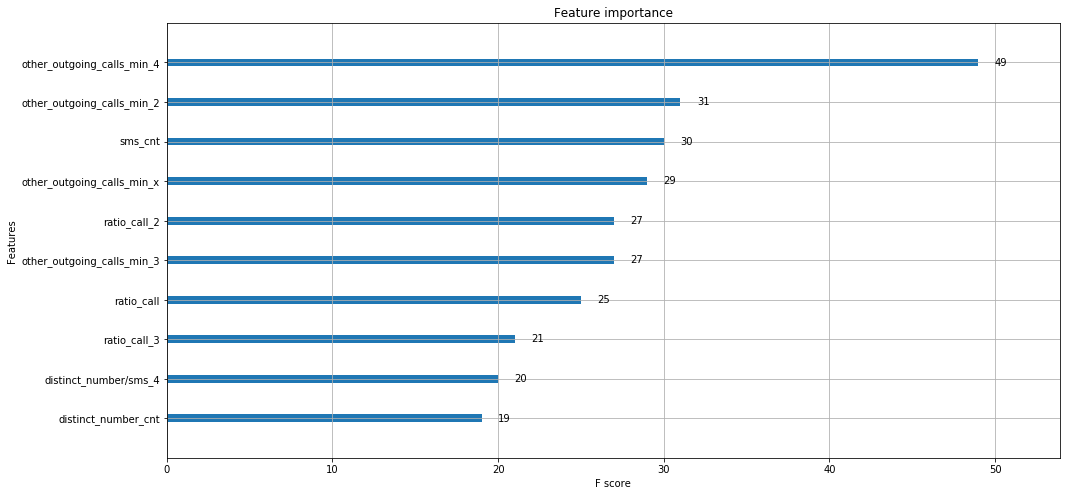

In [34]:
plt.rcParams["figure.figsize"] = (16,8)
plot_importance(xgb, max_num_features = 10)
plt.show()

In [35]:
sorted_idx = np.argsort(xgb.feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index],100*xgb.feature_importances_[index]]) 

['distinct_number_cnt_4', 4.020706191658974]
['distinct_number_cnt_3', 3.315802291035652]
['distinct_number_cnt_2', 3.1829431653022766]
['distinct_number_cnt', 2.88070198148489]
['std_call_to_period', 2.045748382806778]
['base_station_cnt_3', 1.0254771448671818]
['sms_cnt_3', 0.9769739583134651]
['base_station_cnt_2', 0.969984382390976]
['sms_cnt', 0.8224489167332649]
['sms_cnt_4', 0.8113192394375801]
['activity_data_4g_days_cnt_2', 0.7598287891596556]
['base_station_cnt_4', 0.6911778822541237]
['activity_data_4g_days_cnt', 0.6831725593656301]
['other_outgoing_calls_min_y', 0.6432244554162025]
['int_outgoing_calls_min_y', 0.6173493340611458]
['mobile_data_4g_mb_x', 0.5977891385555267]
['total_outgoing_revenue_core_4', 0.5771334748715162]
['mobile_data_4g_mb_5', 0.5687161348760128]
['mobile_data_4g_mb_3', 0.5667760036885738]
['total_outgoing_revenue_core_2', 0.5524350795894861]
['other_outgoing_calls_min_4', 0.5481930915266275]
['other_outgoing_calls_min_3', 0.5200095474720001]
['ratio_

['mean_call_to_period', 0.25226431898772717]
['on_net_outgoing_calls_min_we_y', 0.2520211972296238]
['roaming_incoming_calls_min_2', 0.25138729251921177]
['int_outgoing_revenue_core_y', 0.2497972920536995]
['int_outgoing_revenue_core_3', 0.24931461084634066]
['total_incoming_calls_count_4', 0.24929593782871962]
['area_city_4', 0.2479511545971036]
['roaming_mobile_data_mb_x', 0.24762863758951426]
['int_outgoing_calls_count_y', 0.24651314597576857]
['off_net_incoming_calls_count_2', 0.2462451346218586]
['off_net_sms_revenue_2', 0.24435727391391993]
['mobile_data_200_free_mb_4', 0.24392837658524513]
['preffered_location_region_2', 0.2438897266983986]
['off_net_itc_cost_5', 0.24385058786720037]
['mobile_data_3g_mb_2', 0.2437198767438531]
['duration_nval_std', 0.24349791929125786]
['off_net_out_revenue_core_bd_5', 0.24295379407703876]
['region_city_5', 0.24279931094497442]
['off_net_sms_cost', 0.24169161915779114]
['on_net_outgoing_calls_min_bd_2', 0.24151764810085297]
['duration_nval_mean'

['roaming_outgoing_revenue_core_2', 0.0]
['sms_revenue_off_net_core_5', 0.0]
['roaming_outgoing_calls_count_2', 0.0]
['int_outgoing_calls_count_2', 0.0]
['roaming_ind_5', 0.0]
['outgoing_sms_int_count_2', 0.0]
['period_x', 0.0]
['roaming_outgoing_calls_min_2', 0.0]
['outgoing_mms_count_we_2', 0.0]
['roaming_sms_revenue_core_bd_2', 0.0]
['sms_revenue_int_core', 0.0]
['roaming_sms_revenue_core_we_2', 0.0]
['sms_revenue_core_we_2', 0.0]
['outgoing_sms_count_we_2', 0.0]
['off_net_out_revenue_core_bd_2', 0.0]
['off_net_out_revenue_core_we_2', 0.0]
['on_net_out_revenue_core_we_2', 0.0]
['period_y', 0.0]
['refilled_amount_y', 0.0]
['on_net_outgoing_calls_count_bd_2', 0.0]
['voice_on_net_ind_y', 0.0]
['r_mob_data_revenue_core_5', 0.0]
['roaming_ind_2', 0.0]
['roaming_sms_revenue_core_we_3', 0.0]
['sms_ind_3', 0.0]
['sms_revenue_core_bd_3', 0.0]
['sms_revenue_core_we_3', 0.0]
['outgoing_mms_count_we_5', 0.0]
['off_net_out_revenue_core_we_3', 0.0]
['on_net_out_revenue_core_we_3', 0.0]
['outgoing

### Ensemble Lightgbm + XGB

In [21]:
%%time

cv = KFold(n_splits=5, shuffle=True, random_state=27)
i=1
results = pd.DataFrame()

models_lgb= []

y_oof_lgb = np.zeros(len(y.values))


for trainIdx, testIdx in cv.split(X, y):
    print(i)
    
# lightgbm
    train_data = lgb.Dataset(X.values[trainIdx], label=y.values[trainIdx])
    test_data = lgb.Dataset(X.values[testIdx], label=y.values[testIdx])
    model = lgb.train(parameters_lgb,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=6000,
                       early_stopping_rounds=300, verbose_eval = 1000)
    
    train_predicted_lgb = model.predict(X.values[trainIdx])
    test_predicted_lgb = model.predict(X.values[testIdx])
    
    #XGBClassifier
    xgb = XGBClassifier(**parameters)
    xgb.fit(X.iloc[trainIdx,:], y[trainIdx]) 
    train_predicted_xgb = xgb.predict_proba(X.iloc[trainIdx,:])[:, 1] 
    test_predicted_xgb = xgb.predict_proba(X.iloc[testIdx,:])[:, 1] 
 
    
    train_predicted_ensemble = 0.95*train_predicted_lgb + 0.05*train_predicted_xgb  
    test_predicted_ensemble = 0.95*test_predicted_lgb + 0.05*test_predicted_lgb
    
    results.loc[i,'accuracy_train'] = accuracy_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'accuracy_test'] = accuracy_score(y[testIdx], test_predicted_ensemble.round())
    
    results.loc[i,'precision_train'] = precision_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'precision_test'] = precision_score(y[testIdx], test_predicted_ensemble.round())
    
    
    results.loc[i,'recall_train'] = recall_score(y[trainIdx], train_predicted_ensemble.round())
    results.loc[i,'recall_test'] = recall_score(y[testIdx], test_predicted_ensemble.round())
    
    
    results.loc[i,'roc_auc_train'] = roc_auc_score(y[trainIdx], train_predicted_ensemble) 
    results.loc[i,'roc_auc_test'] = roc_auc_score(y[testIdx], test_predicted_ensemble) 
    
    results.loc[i,'f1_score_train'] = f1_score(y[trainIdx], train_predicted_ensemble.round()) 
    results.loc[i,'f1_score_test'] = f1_score(y[testIdx], test_predicted_ensemble.round()) 
    models_lgb.append(model)
    
    i+=1

1
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.833078
[2000]	valid_0's auc: 0.834965
Early stopping, best iteration is:
[1843]	valid_0's auc: 0.835334
2
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.828102
[2000]	valid_0's auc: 0.829601
Early stopping, best iteration is:
[2628]	valid_0's auc: 0.830076
3
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.838502
[2000]	valid_0's auc: 0.840689
[3000]	valid_0's auc: 0.841901
[4000]	valid_0's auc: 0.842256
Early stopping, best iteration is:
[3724]	valid_0's auc: 0.842796
4
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.832806
Early stopping, best iteration is:
[1284]	valid_0's auc: 0.833186
5
Training until validation scores don't improve for 300 rounds.
[1000]	valid_0's auc: 0.835952
[2000]	valid_0's auc: 0.840585
[3000]	valid_0's auc: 0.842024
Early stopping, best iteration is:
[272

In [22]:
np.mean(results)

accuracy_train    0.9406454
accuracy_test     0.9049450
precision_train   0.9444453
precision_test    0.6378588
recall_train      0.4626891
recall_test       0.2298306
roc_auc_train     0.9643556
roc_auc_test      0.8367318
f1_score_train    0.6188462
f1_score_test     0.3377351
dtype: float64